In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.6.0-dev20210602


In [2]:
def plot_series(time, series, format = "-", start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
def trend(time, slope = 0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(
        season_time < 0.4,
        np.cos(season_time*2*np.pi),
        1 / np.exp(3 * season_time)
    )

def seasonality(time, period, amplitude = 1, phase = 0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level = 1, seed = None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [4]:
time = np.arange(4*365 + 1, dtype = "float32")
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

In [5]:
series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)
series += noise(time, noise_level, seed = 42)

In [6]:
for i in range(len(time)):
    print(series[i])

52.48357
49.35275
53.314735
57.711823
48.934444
48.931244
57.982895
53.897125
47.67393
52.68371
47.591717
47.506374
50.959415
40.086178
40.919415
46.612473
44.228207
50.720642
44.454983
41.76799
55.980938
47.335835
48.6033
40.93184
45.11266
48.15732
41.6051
48.985233
43.839634
45.109936
43.275043
55.24983
45.615612
40.079105
49.154957
38.602703
45.406162
34.208767
37.00193
44.25351
46.578594
43.35101
41.514812
40.177532
33.871693
37.237713
38.097908
45.242546
41.222683
30.229015
40.196377
36.174564
34.231815
40.183838
41.78223
40.778324
31.413605
33.544636
36.221428
38.910835
31.098982
32.022236
26.868631
25.863333
35.345516
37.49725
29.783985
34.584698
30.793396
25.17319
29.614908
34.90301
26.434551
33.833897
12.305289
28.903387
24.615705
22.06895
23.403429
12.384742
20.599699
22.856821
27.831846
17.22026
15.136701
16.036467
22.487074
18.91756
13.98788
18.565226
15.84603
19.565367
10.573323
11.806878
10.846607
4.8520856
13.013545
12.202472
10.28818
8.456475
1.9209299
6.2647085
6.02649

In [7]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

In [8]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis = -1)
    
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    
    return ds.batch(batch_size).prefetch(1)

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    
    forecast = model.predict(ds)
    return forecast

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [12]:
window_size = 30
train_set = windowed_dataset(
    x_train, 
    window_size, 
    batch_size = 128, 
    shuffle_buffer = shuffle_buffer_size
)

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(
        filters = 32,
        kernel_size = 5,
        strides = 1,
        padding = "causal",
        activation = "relu",
        input_shape = [None, 1]
    ),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, return_sequences = True)
    ),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, return_sequences = True)
    ),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*200)
])

In [14]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch/20)
)

optimizer = tf.keras.optimizers.SGD(
    learning_rate = 1e-8,
    momentum = 0.9
)

model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ["mae"]
)

In [15]:
history = model.fit(
    train_set,
    epochs = 100,
    callbacks = [lr_schedule]
)

Epoch 1/100
8/8 [==============================] - 4s 29ms/step - loss: 73.1912 - mae: 73.6904
Epoch 2/100
8/8 [==============================] - 0s 27ms/step - loss: 72.4799 - mae: 72.9791
Epoch 3/100
8/8 [==============================] - 0s 29ms/step - loss: 71.3446 - mae: 71.8437
Epoch 4/100
8/8 [==============================] - 0s 27ms/step - loss: 69.9230 - mae: 70.4223
Epoch 5/100
8/8 [==============================] - 0s 28ms/step - loss: 68.2678 - mae: 68.7669
Epoch 6/100
8/8 [==============================] - 0s 28ms/step - loss: 66.3621 - mae: 66.8609
Epoch 7/100
8/8 [==============================] - 0s 27ms/step - loss: 64.2432 - mae: 64.7424
Epoch 8/100
8/8 [==============================] - 0s 28ms/step - loss: 61.8749 - mae: 62.3738
Epoch 9/100
8/8 [==============================] - 0s 28ms/step - loss: 59.2491 - mae: 59.7479
Epoch 10/100
8/8 [==============================] - 0s 28ms/step - loss: 56.3267 - mae: 56.8254
Epoch 11/100
8/8 [==============================]

8/8 [==============================] - 0s 28ms/step - loss: 21.9335 - mae: 22.4304
Epoch 88/100
8/8 [==============================] - 0s 28ms/step - loss: 22.2468 - mae: 22.7429
Epoch 89/100
8/8 [==============================] - 0s 28ms/step - loss: 12.2872 - mae: 12.7791
Epoch 90/100
8/8 [==============================] - 0s 28ms/step - loss: 19.5477 - mae: 20.0446
Epoch 91/100
8/8 [==============================] - 0s 27ms/step - loss: 14.1280 - mae: 14.6230
Epoch 92/100
8/8 [==============================] - 0s 27ms/step - loss: 13.2907 - mae: 13.7836
Epoch 93/100
8/8 [==============================] - 0s 29ms/step - loss: 23.0406 - mae: 23.5381
Epoch 94/100
8/8 [==============================] - 0s 27ms/step - loss: 16.8172 - mae: 17.3112
Epoch 95/100
8/8 [==============================] - 0s 28ms/step - loss: 17.4208 - mae: 17.9152
Epoch 96/100
8/8 [==============================] - 0s 28ms/step - loss: 21.2529 - mae: 21.7496
Epoch 97/100
8/8 [==============================] - 0

(1e-08, 0.0001, 0.0, 30.0)

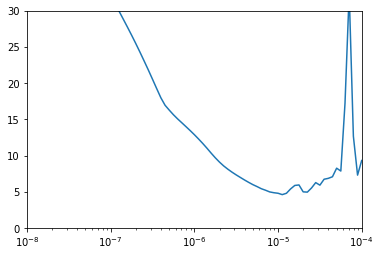

In [16]:
plt.semilogx(
    history.history["lr"],
    history.history["loss"]
)

plt.axis(
    [1e-8, 1e-4, 0, 30]
)

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
tf.compat.v1.set_random_seed(51)

In [18]:
batch_size = 16

dataset = windowed_dataset(
    x_train,
    window_size,
    batch_size,
    shuffle_buffer_size
)

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(
        filters = 32,
        kernel_size = 3,
        strides = 1,
        padding = "causal",
        activation = "relu",
        input_shape = [None, 1]
    ),
    tf.keras.layers.LSTM(32, return_sequences = True),
    tf.keras.layers.LSTM(32, return_sequences = True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*200)
])

In [20]:
optimizer = tf.keras.optimizers.SGD(
    learning_rate = 1e-5,
    momentum = 0.9
)

model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ["mae"]
)

In [21]:
history = model.fit( dataset, epochs = 500, verbose = 1 )

Epoch 1/500
61/61 [==============================] - 4s 23ms/step - loss: 14.2370 - mae: 14.7256
Epoch 2/500
61/61 [==============================] - 1s 22ms/step - loss: 6.6426 - mae: 7.1248
Epoch 3/500
61/61 [==============================] - 1s 23ms/step - loss: 5.7821 - mae: 6.2621
Epoch 4/500
61/61 [==============================] - 1s 22ms/step - loss: 5.4753 - mae: 5.9542
Epoch 5/500
61/61 [==============================] - 2s 23ms/step - loss: 5.2971 - mae: 5.7766
Epoch 6/500
61/61 [==============================] - 1s 23ms/step - loss: 5.2834 - mae: 5.7633
Epoch 7/500
61/61 [==============================] - 1s 22ms/step - loss: 5.2166 - mae: 5.6954
Epoch 8/500
61/61 [==============================] - 1s 23ms/step - loss: 5.0249 - mae: 5.5027
Epoch 9/500
61/61 [==============================] - 1s 23ms/step - loss: 5.0530 - mae: 5.5319
Epoch 10/500
61/61 [==============================] - 1s 23ms/step - loss: 5.0427 - mae: 5.5214
Epoch 11/500
61/61 [===========================

61/61 [==============================] - 1s 23ms/step - loss: 4.1636 - mae: 4.6376
Epoch 87/500
61/61 [==============================] - 1s 22ms/step - loss: 4.1688 - mae: 4.6430
Epoch 88/500
61/61 [==============================] - 1s 23ms/step - loss: 4.1201 - mae: 4.5938
Epoch 89/500
61/61 [==============================] - 1s 22ms/step - loss: 4.3646 - mae: 4.8400
Epoch 90/500
61/61 [==============================] - 1s 23ms/step - loss: 4.1598 - mae: 4.6336
Epoch 91/500
61/61 [==============================] - 1s 23ms/step - loss: 4.1705 - mae: 4.6445
Epoch 92/500
61/61 [==============================] - 1s 23ms/step - loss: 4.1569 - mae: 4.6317
Epoch 93/500
61/61 [==============================] - 1s 23ms/step - loss: 4.1636 - mae: 4.6379
Epoch 94/500
61/61 [==============================] - 1s 23ms/step - loss: 4.1519 - mae: 4.6256
Epoch 95/500
61/61 [==============================] - 1s 23ms/step - loss: 4.2088 - mae: 4.6834
Epoch 96/500
61/61 [==============================] -

61/61 [==============================] - 1s 23ms/step - loss: 3.9984 - mae: 4.4710
Epoch 171/500
61/61 [==============================] - 1s 23ms/step - loss: 3.9820 - mae: 4.4551
Epoch 172/500
61/61 [==============================] - 1s 23ms/step - loss: 4.1047 - mae: 4.5787
Epoch 173/500
61/61 [==============================] - 1s 22ms/step - loss: 4.0315 - mae: 4.5048
Epoch 174/500
61/61 [==============================] - 1s 23ms/step - loss: 4.0027 - mae: 4.4757
Epoch 175/500
61/61 [==============================] - 1s 23ms/step - loss: 3.9857 - mae: 4.4589
Epoch 176/500
61/61 [==============================] - 1s 23ms/step - loss: 4.0205 - mae: 4.4933
Epoch 177/500
61/61 [==============================] - 1s 23ms/step - loss: 3.9650 - mae: 4.4378
Epoch 178/500
61/61 [==============================] - 1s 23ms/step - loss: 3.9995 - mae: 4.4724
Epoch 179/500
61/61 [==============================] - 1s 23ms/step - loss: 3.9700 - mae: 4.4432
Epoch 180/500
61/61 [=======================

61/61 [==============================] - 1s 23ms/step - loss: 3.9547 - mae: 4.4266
Epoch 255/500
61/61 [==============================] - 1s 23ms/step - loss: 3.9534 - mae: 4.4260
Epoch 256/500
61/61 [==============================] - 1s 23ms/step - loss: 3.9871 - mae: 4.4606
Epoch 257/500
61/61 [==============================] - 1s 23ms/step - loss: 3.9448 - mae: 4.4173
Epoch 258/500
61/61 [==============================] - 1s 22ms/step - loss: 3.9305 - mae: 4.4020
Epoch 259/500
61/61 [==============================] - 1s 23ms/step - loss: 3.9908 - mae: 4.4635
Epoch 260/500
61/61 [==============================] - 1s 23ms/step - loss: 3.9402 - mae: 4.4124
Epoch 261/500
61/61 [==============================] - 1s 23ms/step - loss: 3.9194 - mae: 4.3909
Epoch 262/500
61/61 [==============================] - 1s 23ms/step - loss: 3.9523 - mae: 4.4238
Epoch 263/500
61/61 [==============================] - 1s 23ms/step - loss: 3.9570 - mae: 4.4297
Epoch 264/500
61/61 [=======================

61/61 [==============================] - 1s 23ms/step - loss: 3.9098 - mae: 4.3817
Epoch 339/500
61/61 [==============================] - 1s 23ms/step - loss: 3.9158 - mae: 4.3875
Epoch 340/500
61/61 [==============================] - 1s 22ms/step - loss: 3.8817 - mae: 4.3516
Epoch 341/500
61/61 [==============================] - 1s 23ms/step - loss: 3.8760 - mae: 4.3469
Epoch 342/500
61/61 [==============================] - 1s 23ms/step - loss: 3.8880 - mae: 4.3594
Epoch 343/500
61/61 [==============================] - 2s 23ms/step - loss: 3.8880 - mae: 4.3590
Epoch 344/500
61/61 [==============================] - 1s 23ms/step - loss: 3.8795 - mae: 4.3500
Epoch 345/500
61/61 [==============================] - 1s 23ms/step - loss: 3.9592 - mae: 4.4316
Epoch 346/500
61/61 [==============================] - 2s 23ms/step - loss: 3.8691 - mae: 4.3396
Epoch 347/500
61/61 [==============================] - 1s 23ms/step - loss: 3.8808 - mae: 4.3520
Epoch 348/500
61/61 [=======================

61/61 [==============================] - 1s 23ms/step - loss: 3.9396 - mae: 4.4117
Epoch 423/500
61/61 [==============================] - 1s 23ms/step - loss: 3.8765 - mae: 4.3476
Epoch 424/500
61/61 [==============================] - 1s 22ms/step - loss: 3.9028 - mae: 4.3740
Epoch 425/500
61/61 [==============================] - 1s 22ms/step - loss: 3.8983 - mae: 4.3693
Epoch 426/500
61/61 [==============================] - 1s 23ms/step - loss: 3.8671 - mae: 4.3383
Epoch 427/500
61/61 [==============================] - 1s 23ms/step - loss: 3.9183 - mae: 4.3896
Epoch 428/500
61/61 [==============================] - 1s 23ms/step - loss: 3.8559 - mae: 4.3256
Epoch 429/500
61/61 [==============================] - 1s 23ms/step - loss: 3.8507 - mae: 4.3214
Epoch 430/500
61/61 [==============================] - 1s 23ms/step - loss: 3.9284 - mae: 4.4012
Epoch 431/500
61/61 [==============================] - 1s 23ms/step - loss: 3.9628 - mae: 4.4347
Epoch 432/500
61/61 [=======================

In [22]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size: -1, -1, 0]

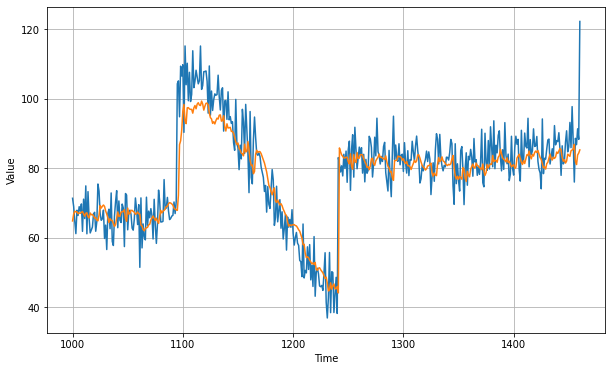

In [23]:
plt.figure(figsize = (10,6))
plot_series(time_valid, x_valid)t
plot_series(time_valid, rnn_forecast)